In [1]:
# Import libraries. 
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import scipy

# 1) Import Dataset

In [2]:
path = r'/Users/amyzhang/Desktop/Instacart Basket Analysis/'

In [5]:
opc = pd.read_pickle(os.path.join(path, '02 Data', 'Prepared Data 2', 'ords_prods_custom_merge.pkl'))

# 2) Address PII data

In [6]:
# Identify PII data
columns_to_drop = ['first name', 'last name']

# Drop the columns
opc.drop(columns=columns_to_drop, axis=1, inplace=True, errors='ignore')

In [7]:
# Verify columns have been dropped. 
opc.columns

Index(['order_id', 'user_id', 'order_number', 'order_day_of_week',
       'order_time', 'days_since_prior_order', 'product_id', 'cart_position',
       'reorder_status', 'product_name', 'aisle_id', 'department_id', 'prices',
       'delinquent_status', '_merge', 'price_range_loc', 'day_label',
       'busiest_period_of_day', 'max_order', 'loyalty_flag', 'avg_order_price',
       'spending_flag', 'median_days_since_prior_order', 'frequency_flag',
       'gender', 'state', 'age', 'date_joined', 'n_dependants', 'fam_status',
       'income', 'merge_2'],
      dtype='object')

In [21]:
# Originally 34 columns; there should now be 2 less. 
opc.shape

(32433030, 32)

# 3) Regional segementation

In [30]:
# Quick glance (check how state names are entered)

In [26]:
opc['state'].describe()

count         32433030
unique              51
top       Pennsylvania
freq            667698
Name: state, dtype: object

In [13]:
# Create region column based on state. 

# Northeast (Region 1)
opc.loc[opc['state'].isin(['Maine', 'New Hampshire', 'Vermont', 'Massachusetts', 'Rhode Island', 
                           'Connecticut', 'New York', 'Pennsylvania']), 'region'] = 'Northeast'

# Midwest (Region 2)
opc.loc[opc['state'].isin(['Wisconsin', 'Michigan', 'Illinois', 'Indiana', 'Ohio', 
                           'North Dakota', 'South Dakota', 'Nebraska', 'Kansas', 
                           'Minnesota', 'Iowa', 'Missouri']), 'region'] = 'Midwest'

# South (Region 3)
opc.loc[opc['state'].isin(['Delaware', 'Maryland', 'District of Columbia', 'Virginia', 'West Virginia', 
                           'North Carolina', 'South Carolina', 'Georgia', 'Florida', 
                           'Kentucky', 'Tennessee', 'Mississippi', 'Alabama', 
                           'Oklahoma', 'Texas', 'Arkansas', 'Louisiana']), 'region'] = 'South'

# West (Region 4)
opc.loc[opc['state'].isin(['Idaho', 'Montana', 'Wyoming', 'Nevada', 'Utah', 'Colorado', 
                           'Arizona', 'New Mexico', 'Alaska', 'Washington', 
                           'Oregon', 'California', 'Hawaii', 'New Jersey']), 'region'] = 'West'

# Assign 'Unknown' for any states not listed
opc['region'] = opc['region'].fillna('Unknown')


In [36]:
opc['region'].value_counts(dropna=False)

region
South        10801195
West          8928418
Midwest       7603550
Northeast     5099867
Name: count, dtype: int64

## Spending habits across U.S. regions

### Regional Distribution of 'spending_flag' 

In [59]:
# Group by 'user_id' and get the first value of 'spending_flag' for each user
grouped_spending = opc.groupby('user_id')['spending_flag'].first().reset_index()

# Count the number of occurrences of each 'spending_flag' value
spending_flag_counts = grouped_spending['spending_flag'].value_counts(dropna=False)

# Display the counts
print(spending_flag_counts)


spending_flag
Low spender     202803
High spender      3406
Name: count, dtype: int64


In [61]:
# Group by both 'region' and 'user_id', and get the first value of 'spending_flag' for each unique user
grouped_spending_region = opc.groupby(['region', 'user_id'])['spending_flag'].first().reset_index()

# Count the number of high and low spenders in each region
spending_counts_by_region = grouped_spending_region.groupby(['region', 'spending_flag'])['user_id'].count().reset_index()

# Rename the columns for clarity
spending_counts_by_region.rename(columns={'user_id': 'count'}, inplace=True)

# Pivot the data to have 'spending_flag' as columns, and 'region' as index
pivot_spending_region = spending_counts_by_region.pivot(index='region', columns='spending_flag', values='count')

# Fill NaN values with 0 for regions without certain flags
pivot_spending_region.fillna(0, inplace=True)

# Display the pivot table (distribution of spenders across regions)
print(pivot_spending_region)


spending_flag  High spender  Low spender
region                                  
Midwest                 803        47716
Northeast               490        31855
South                  1149        67588
West                    964        55644


In [63]:
# Data is consistent: 
# 48,519 (Midwest) + 32,345 (Northeast) + 68,737 (South) + 56,608 (West) = 206,209 customers

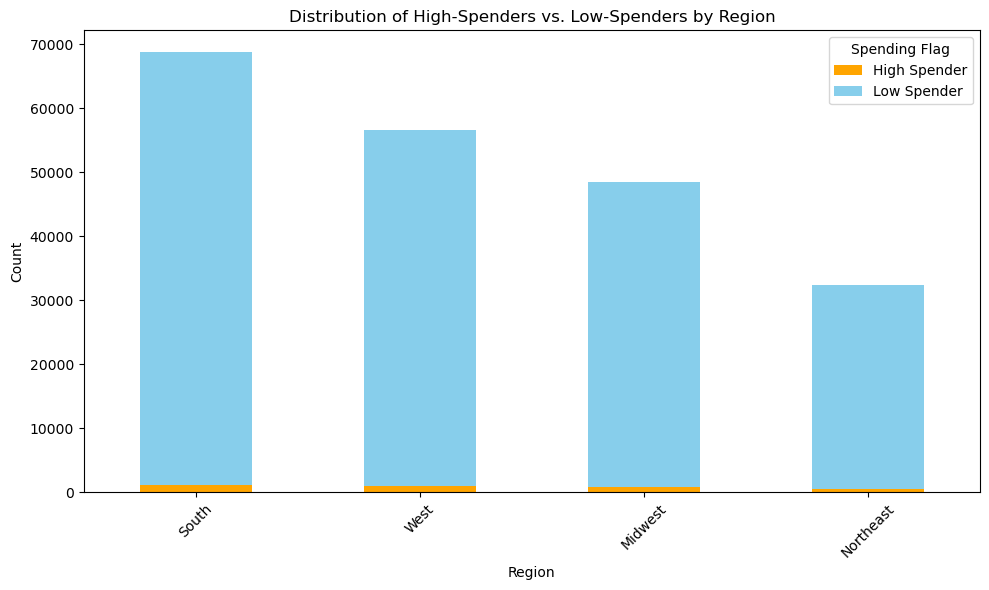

In [88]:
# Calculate the total counts for sorting
pivot_spending_region['Total'] = pivot_spending_region.sum(axis=1)

# Sort the DataFrame by the 'Total' column in descending order
pivot_spending_region = pivot_spending_region.sort_values(by='Total', ascending=False)

# Drop the 'Total' column (if not needed for plotting)
pivot_spending_region = pivot_spending_region.drop(columns='Total')

# Create a figure and axes for plotting
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the sorted stacked bar chart
pivot_spending_region.plot(
    kind='bar',
    stacked=True,
    ax=ax,  # Use the axes object
    color=['orange', 'skyblue'],  # Correct color assignment
)

# Customize the chart
ax.set_title('Distribution of High-Spenders vs. Low-Spenders by Region')
ax.set_ylabel('Count')
ax.set_xlabel('Region')
ax.legend(title='Spending Flag', labels=['High Spender', 'Low Spender'])  # Ensure legend labels match the colors
plt.xticks(rotation=45)

# Show the plot
plt.tight_layout()
plt.show()


In [90]:
# Define the directory and file name
output_dir = '/Users/amyzhang/Desktop/Instacart Basket Analysis/04 Analysis/Visualizations'
file_name = 'Region_Spending_barchart.png'

# Construct the full file path
output_path = os.path.join(output_dir, file_name)

# Save the plot
fig.savefig(output_path, format='png')

# Print a message confirming the save
print(f"Plot saved to {output_path}")

Plot saved to /Users/amyzhang/Desktop/Instacart Basket Analysis/04 Analysis/Visualizations/Region_Spending_barchart.png


### Regional Distribution of 'loyalty_flag' (based on a user's max number of orders) 

In [77]:
# Group by both 'region' and 'user_id', and get the first value of 'loyalty_flag' for each unique user
grouped_loyalty_region = opc.groupby(['region', 'user_id'])['loyalty_flag'].first().reset_index()

# Count the number of loyal, new, and regular customers in each region
loyalty_counts_by_region = grouped_loyalty_region.groupby(['region', 'loyalty_flag'])['user_id'].count().reset_index()

# Rename the columns for clarity
loyalty_counts_by_region.rename(columns={'user_id': 'count'}, inplace=True)

# Pivot the data to have 'loyalty_flag' as columns, and 'region' as index
pivot_loyalty_region = loyalty_counts_by_region.pivot(index='region', columns='loyalty_flag', values='count')

# Fill NaN values with 0 for regions without certain flags
pivot_loyalty_region.fillna(0, inplace=True)

# Display the pivot table (distribution of loyalty_flag across regions)
print(pivot_loyalty_region)


loyalty_flag  Loyal customer  New customer  Regular customer
region                                                      
Midwest                 3991         26333             18195
Northeast               2702         17623             12020
South                   5637         37491             25609
West                    4687         30881             21040


(array([0, 1, 2, 3]),
 [Text(0, 0, 'South'),
  Text(1, 0, 'West'),
  Text(2, 0, 'Midwest'),
  Text(3, 0, 'Northeast')])

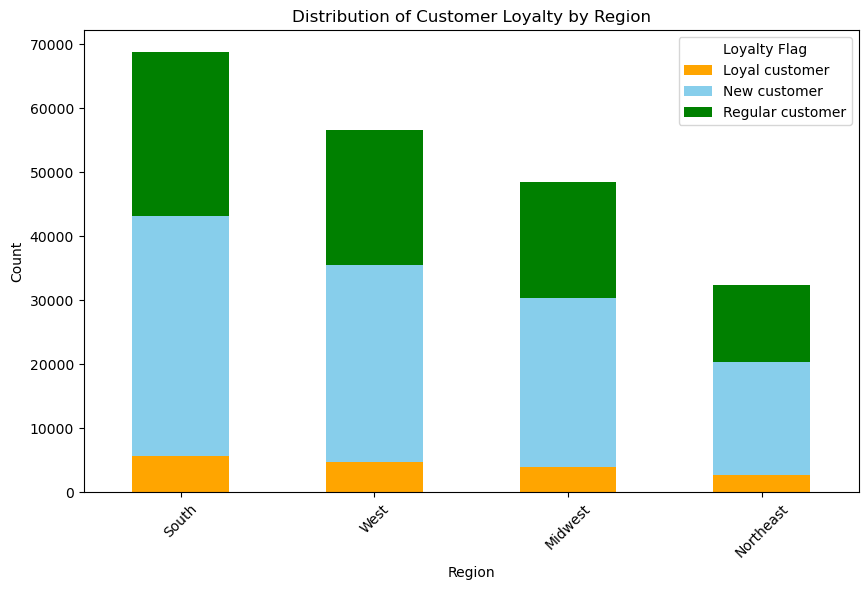

In [96]:
# Calculate the total counts for sorting
pivot_loyalty_region['Total'] = pivot_loyalty_region.sum(axis=1)

# Sort the DataFrame by the 'Total' column (descending)
pivot_loyalty_region = pivot_loyalty_region.sort_values(by='Total', ascending=False)

# Drop the 'Total' column (not needed for plotting)
pivot_loyalty_region = pivot_loyalty_region.drop(columns='Total')

# Create a separate figure and axes for the Loyalty chart
fig_loyalty, ax_loyalty = plt.subplots(figsize=(10, 6))

# Plot the sorted stacked bar chart for Loyalty
pivot_loyalty_region.plot(
    kind='bar',
    stacked=True,
    ax=ax_loyalty,  # Use the axes object
    color=['orange', 'skyblue', 'green'],
)

# Customize the chart
ax_loyalty.set_title('Distribution of Customer Loyalty by Region')
ax_loyalty.set_ylabel('Count')
ax_loyalty.set_xlabel('Region')
ax_loyalty.legend(title='Loyalty Flag', labels=['Loyal customer', 'New customer', 'Regular customer'])  # Ensure legend labels match the colors
plt.xticks(rotation=45)

In [98]:
# Save the Loyalty chart to a unique file name
output_dir = '/Users/amyzhang/Desktop/Instacart Basket Analysis/04 Analysis/Visualizations'
file_name_loyalty = 'Region_Loyalty_barchart.png'  # Unique file name for Loyalty chart
output_path_loyalty = os.path.join(output_dir, file_name_loyalty)
fig_loyalty.savefig(output_path_loyalty, format='png')

# Print a message confirming the save
print(f"Loyalty plot saved to {output_path_loyalty}")

# Show the plot
plt.tight_layout()
plt.show()

Loyalty plot saved to /Users/amyzhang/Desktop/Instacart Basket Analysis/04 Analysis/Visualizations/Region_Loyalty_barchart.png


<Figure size 640x480 with 0 Axes>

### Regional Distribution of 'frequency flag' (based on median days_since_prior_order)

In [15]:
# Group by both 'region' and 'user_id', and get the first value of 'frequency_flag' for each unique user
grouped_frequency_region = opc.groupby(['region', 'user_id'])['frequency_flag'].first().reset_index()

# Count the number of customer types in each region
frequency_counts_by_region = grouped_frequency_region.groupby(['region', 'frequency_flag'])['user_id'].count().reset_index()

# Rename the columns for clarity
frequency_counts_by_region.rename(columns={'user_id': 'count'}, inplace=True)

# Pivot the data to have 'loyalty_flag' as columns, and 'region' as index
pivot_frequency_region = frequency_counts_by_region.pivot(index='region', columns='frequency_flag', values='count')

# Fill NaN values with 0 for regions without certain flags
pivot_frequency_region.fillna(0, inplace=True)

# Display the pivot table (distribution of loyalty_flag across regions)
print(pivot_frequency_region)

frequency_flag  Frequent customer  Not frequent customer  Regular customer
region                                                                    
Midwest                     20280                  14061             14178
Northeast                   13576                   9211              9558
South                       28866                  19933             19938
West                        23869                  16411             16328


(array([0, 1, 2, 3]),
 [Text(0, 0, 'South'),
  Text(1, 0, 'West'),
  Text(2, 0, 'Midwest'),
  Text(3, 0, 'Northeast')])

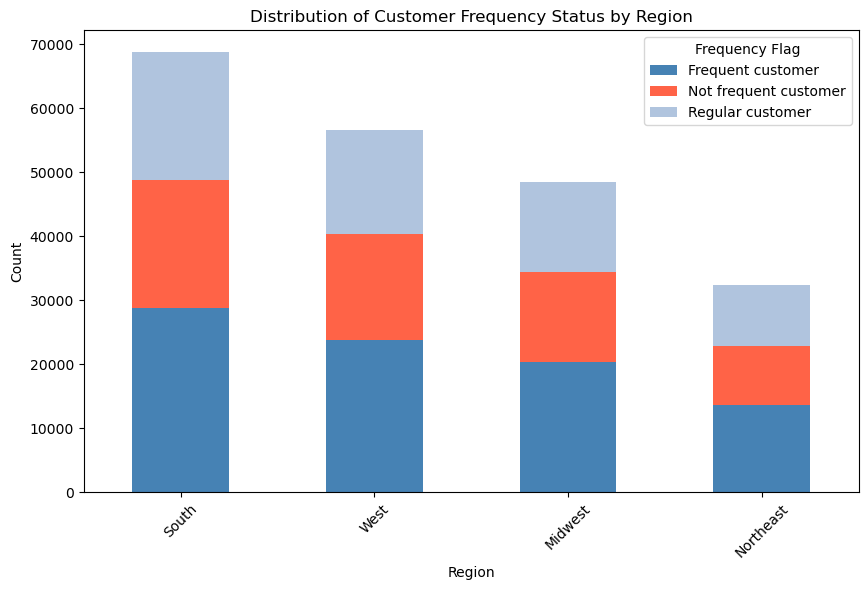

In [26]:
# Create a separate figure and axes for the Frequency chart
fig_frequency, ax_frequency = plt.subplots(figsize=(10, 6))

# Plot the sorted stacked bar chart for Frequency
pivot_frequency_region.plot(
    kind='bar',
    stacked=True,
    ax=ax_frequency,  # Use the axes object
    color=['#4682B4', '#FF6347', '#B0C4DE'],  # Steel Blue, Tomato, Light Steel Blue
)

# Customize the chart
ax_frequency.set_title('Distribution of Customer Frequency Status by Region')
ax_frequency.set_ylabel('Count')
ax_frequency.set_xlabel('Region')
ax_frequency.legend(title='Frequency Flag', labels=['Frequent customer', 'Not frequent customer', 'Regular customer'])  # Ensure legend labels match the colors
plt.xticks(rotation=45)


In [28]:
# Save the Frequency chart to a unique file name
output_dir = '/Users/amyzhang/Desktop/Instacart Basket Analysis/04 Analysis/Visualizations'
file_name_frequency = 'Region_Frequency_barchart.png'  # Unique file name for Loyalty chart
output_path_frequency = os.path.join(output_dir, file_name_frequency)
fig_frequency.savefig(output_path_frequency, format='png')

# Print a message confirming the save
print(f"Frequency plot saved to {output_path_frequency}")

# Show the plot
plt.tight_layout()
plt.show()

Frequency plot saved to /Users/amyzhang/Desktop/Instacart Basket Analysis/04 Analysis/Visualizations/Region_Frequency_barchart.png


<Figure size 640x480 with 0 Axes>

# 4) Exclusion of Low-Activity Customers (max_order < 5) 

In [33]:
# 1. Create the exclusion flag for low-activity customers (less than 5 orders)
opc.loc[opc['max_order'] < 5, 'low_act_flag'] = 'low_activity_customer'

# 2. Filter out low-activity customers by user_id
low_activity_customers = opc[opc['low_act_flag'] == 'low_activity_customer']
opc_filtered = opc[~opc['user_id'].isin(low_activity_customers['user_id'])]

In [37]:
opc_filtered['low_act_flag'].value_counts()

Series([], Name: count, dtype: int64)

In [39]:
opc_filtered['low_act_flag'].value_counts(dropna=False)

low_act_flag
NaN    30991542
Name: count, dtype: int64

In [45]:
low_activity_customers.shape

(1441488, 34)

In [57]:
opc_filtered.head()

,order_id,user_id,order_number,order_day_of_week,order_time,days_since_prior_order,product_id,cart_position,reorder_status,product_name,...,gender,state,age,date_joined,n_dependants,fam_status,income,merge_2,region,low_act_flag
0,2539329,1,1,2,8,NaN,196,1,0,Soda,...,Female,Alabama,31,2/17/2019,3,married,40423,both,South,NaN
1,2539329,1,1,2,8,NaN,14084,2,0,Organic Unsweetened Vanilla Almond Milk,...,Female,Alabama,31,2/17/2019,3,married,40423,both,South,NaN
2,2539329,1,1,2,8,NaN,12427,3,0,Original Beef Jerky,...,Female,Alabama,31,2/17/2019,3,married,40423,both,South,NaN
3,2539329,1,1,2,8,NaN,26088,4,0,Aged White Cheddar Popcorn,...,Female,Alabama,31,2/17/2019,3,married,40423,both,South,NaN
4,2539329,1,1,2,8,NaN,26405,5,0,XL Pick-A-Size Paper Towel Rolls,...,Female,Alabama,31,2/17/2019,3,married,40423,both,South,NaN


In [61]:
opc_filtered.columns

Index(['order_id', 'user_id', 'order_number', 'order_day_of_week',
       'order_time', 'days_since_prior_order', 'product_id', 'cart_position',
       'reorder_status', 'product_name', 'aisle_id', 'department_id', 'prices',
       'delinquent_status', '_merge', 'price_range_loc', 'day_label',
       'busiest_period_of_day', 'max_order', 'loyalty_flag', 'avg_order_price',
       'spending_flag', 'median_days_since_prior_order', 'frequency_flag',
       'gender', 'state', 'age', 'date_joined', 'n_dependants', 'fam_status',
       'income', 'merge_2', 'region', 'low_act_flag'],
      dtype='object')

In [71]:
# Take out unnecessary columns before exporting. 
columns_to_drop = ['_merge', 'aisle_id', 'merge_2', 'low_act_flag']

# Drop the columns
opc_filtered.drop(columns=columns_to_drop, axis=1, inplace=True, errors='ignore')

# Verify the columns have been removed
print(opc_filtered.columns)  

Index(['order_id', 'user_id', 'order_number', 'order_day_of_week',
       'order_time', 'days_since_prior_order', 'product_id', 'cart_position',
       'reorder_status', 'product_name', 'department_id', 'prices',
       'delinquent_status', 'price_range_loc', 'day_label',
       'busiest_period_of_day', 'max_order', 'loyalty_flag', 'avg_order_price',
       'spending_flag', 'median_days_since_prior_order', 'frequency_flag',
       'gender', 'state', 'age', 'date_joined', 'n_dependants', 'fam_status',
       'income', 'region'],
      dtype='object')


/var/folders/6r/kznwmt6j1rsfwtfplchqpwj00000gn/T/ipykernel_88866/1747802531.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  opc_filtered.drop(columns=columns_to_drop, axis=1, inplace=True, errors='ignore')


In [73]:
opc_filtered.shape

(30991542, 30)

In [76]:
# Export dataframe. 
opc_filtered.to_pickle(os.path.join(path, '02 Data','Prepared Data 2', 'opc_filtered.pkl'))

In [130]:
unique_users_count = opc_filtered['user_id'].nunique()
print(f"Number of unique users: {unique_users_count}")

Number of unique users: 162633


In [163]:
unique_users_count_original = opc['user_id'].nunique()
print(f"Number of unique users originally: {unique_users_count_original}")

Number of unique users originally: 206209


#### 37,576 customers were low-activity (fewer than 5 orders). 

# Section below is moot. 

# -- SEE '4.10 Part 1b' -- 

## 5) Customer Profiles

### 1. 'Adventurous Shoppers' vs. 'Creatures of Habit' vs. 'Open to Suggestion'
#### (based on the proportion of purchases that are reorders) 

#### Step 1. Group by 'user_id' and count 'reorder_status'

In [93]:
# Group by user_id and calculate total products and total reorders
user_activity = opc_filtered.groupby('user_id').agg(
    total_products=('product_id', 'count'),  # Count total number of products ordered by user
    total_reorders=('reorder_status', 'sum')  # Sum the reorders (1 indicates reorder)
)

In [95]:
user_activity.head()

,total_products,total_reorders
user_id,,
1,59,41
10,143,49
100,27,7
1000,103,71
10000,1092,836


#### Step 2. Calculate the reorder proportion. 

In [99]:
# Calculate the reorder proportion for each user
user_activity['reorder_proportion'] = user_activity['total_reorders'] / user_activity['total_products']

In [101]:
user_activity.head()

,total_products,total_reorders,reorder_proportion
user_id,,,
1,59,41,0.694915
10,143,49,0.342657
100,27,7,0.259259
1000,103,71,0.689320
10000,1092,836,0.765568


In [105]:
# Sort the DataFrame by 'reorder_proportion' in descending order and display the top 20 rows
user_activity.sort_values(by='reorder_proportion', ascending=False).head(20)

,total_products,total_reorders,reorder_proportion
user_id,,,
99753,191,189,0.989529
82414,428,420,0.981308
107528,104,102,0.980769
17997,435,426,0.979310
5588,2223,2176,0.978857
170174,47,46,0.978723
3269,275,269,0.978182
12025,45,44,0.977778
91160,212,207,0.976415


In [109]:
user_activity.describe()

,total_products,total_reorders,reorder_proportion
count,162633.000000,162633.000000,162633.000000
mean,190.561215,115.519409,0.487637
std,217.941363,171.284015,0.192391
min,5.000000,0.000000,0.000000
25%,59.000000,21.000000,0.345794
50%,114.000000,51.000000,0.491525
75%,233.000000,133.000000,0.634021
max,3725.000000,3275.000000,0.989529


#### Step 3. Visualize the distribution with a box plot. 

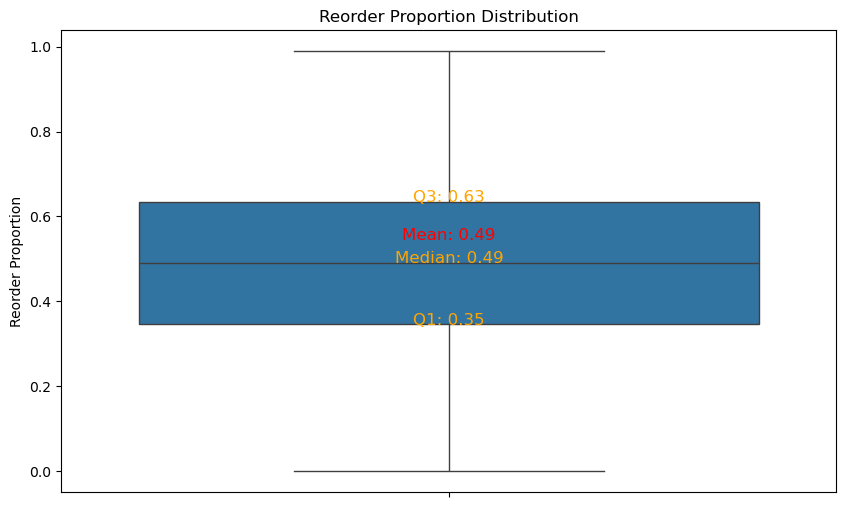

In [118]:
# Create the box plot
fig_reorder = plt.figure(figsize=(10, 6))
ax_reorder = sns.boxplot(data=user_activity['reorder_proportion'])

# Calculate quartiles and mean
q1 = user_activity['reorder_proportion'].quantile(0.25)
q2 = user_activity['reorder_proportion'].quantile(0.5)  # Median
q3 = user_activity['reorder_proportion'].quantile(0.75)
mean = user_activity['reorder_proportion'].mean()

# Add text annotations for quartiles and mean
plt.text(0, q1, f'Q1: {q1:.2f}', horizontalalignment='center', color='orange', fontsize=12)
plt.text(0, q2, f'Median: {q2:.2f}', horizontalalignment='center', color='orange', fontsize=12)
plt.text(0, q3, f'Q3: {q3:.2f}', horizontalalignment='center', color='orange', fontsize=12)

# Offset mean annotation above the box plot
plt.text(0, mean + 0.05, f'Mean: {mean:.2f}', horizontalalignment='center', color='red', fontsize=12, verticalalignment='bottom')

# Title and labels
plt.title('Reorder Proportion Distribution')
plt.ylabel('Reorder Proportion')

# Show the plot
plt.show()


In [120]:
# Export visualization. 

# Save to a unique file name
output_dir = '/Users/amyzhang/Desktop/Instacart Basket Analysis/04 Analysis/Visualizations'
file_name_reorder = 'Reorder_BoxPlot.png'  
output_path_reorder = os.path.join(output_dir, file_name_reorder)

# Save the plot to the correct path
fig_reorder.savefig(output_path_reorder, format='png')

# Print a message confirming the save
print(f"Reorder box-plot saved to {output_path_reorder}")


Reorder box-plot saved to /Users/amyzhang/Desktop/Instacart Basket Analysis/04 Analysis/Visualizations/Reorder_BoxPlot.png


#### Step 4. Define Adventurous Shoppers vs. Creatures of Habit vs. Orpen to Suggestion customers

In [153]:
# Get the quartiles
reorder_quantiles = user_activity['reorder_proportion'].quantile([0.25, 0.5, 0.75])

# Define adventurous shoppers, open to suggestion, and creatures of habit
adventurous_shoppers = user_activity[user_activity['reorder_proportion'] <= reorder_quantiles[0.25]]
open_to_suggestion = user_activity[(user_activity['reorder_proportion'] > reorder_quantiles[0.25]) & (user_activity['reorder_proportion'] <= reorder_quantiles[0.75])]

creatures_of_habit = user_activity[user_activity['reorder_proportion'] >= reorder_quantiles[0.75]]

In [126]:
# Count the number of users in each category
num_adventurous_shoppers = len(adventurous_shoppers)
num_open_to_suggestion = len(open_to_suggestion)
num_creatures_of_habit = len(creatures_of_habit)

# Print the results
print(f"Number of Adventurous Shoppers: {num_adventurous_shoppers}")
print(f"Number of Open to Suggestion Shoppers: {num_open_to_suggestion}")
print(f"Number of Creatures of Habit: {num_creatures_of_habit}")

Number of Adventurous Shoppers: 40670
Number of Open to Suggestion Shoppers: 81306
Number of Creatures of Habit: 40664


In [172]:
# 162,640 vs. 162,633 unique customers in opc_filtered.

#### DEBUG: look for the extra 7

In [132]:
# Check for overlaps
overlap = adventurous_shoppers.merge(open_to_suggestion, on='user_id')
print(f"Overlapping users between adventurous_shoppers and open_to_suggestion: {len(overlap)}")


Overlapping users between adventurous_shoppers and open_to_suggestion: 0


In [138]:
# Check for overlaps
overlap = open_to_suggestion.merge(creatures_of_habit, on='user_id')
print(f"Overlapping users between open_to_suggestion and creatures_of_habit: {len(overlap)}")

Overlapping users between open_to_suggestion and creatures_of_habit: 7


In [159]:
# Define open_to_suggestion correctly
# Ensure there is no overlap by using strict inequalities to separate the categories!
open_to_suggestion = user_activity[
    (user_activity['reorder_proportion'] > reorder_quantiles[0.25]) & 
    (user_activity['reorder_proportion'] < reorder_quantiles[0.75])
]

# Define adventurous shoppers and creatures of habit without overlap
adventurous_shoppers = user_activity[user_activity['reorder_proportion'] <= reorder_quantiles[0.25]]
creatures_of_habit = user_activity[user_activity['reorder_proportion'] >= reorder_quantiles[0.75]]

# Now recheck the overlaps
overlap = open_to_suggestion.merge(creatures_of_habit, on='user_id')
print(f"Overlapping users between open_to_suggestion and creatures_of_habit: {len(overlap)}")

Overlapping users between open_to_suggestion and creatures_of_habit: 0


In [161]:
# Count the number of users in each category
num_adventurous_shoppers = len(adventurous_shoppers)
num_open_to_suggestion = len(open_to_suggestion)
num_creatures_of_habit = len(creatures_of_habit)

# Print the results
print(f"Number of Adventurous Shoppers: {num_adventurous_shoppers}")
print(f"Number of Open to Suggestion Shoppers: {num_open_to_suggestion}")
print(f"Number of Creatures of Habit: {num_creatures_of_habit}")

Number of Adventurous Shoppers: 40670
Number of Open to Suggestion Shoppers: 81299
Number of Creatures of Habit: 40664


#### Regional Distribution

In [193]:
# user_id not included in previous user_activity df; have to reset the index

In [190]:
# Group by user_id and calculate total products and total reorders
user_activity = opc_filtered.groupby('user_id').agg(
    total_products=('product_id', 'count'),  # Count total number of products ordered by user
    total_reorders=('reorder_status', 'sum')  # Sum the reorders (1 indicates reorder)
).reset_index()  # Reset the index to make 'user_id' a column again

In [201]:
def reorder_habit(reorder_proportion, q1, q3):
    if reorder_proportion <= q1:
        return 'Adventurous Shopper'
    elif reorder_proportion >= q3:
        return 'Creature of Habit'
    else:
        return 'Open to Suggestion'

In [203]:
# Step 4: Apply the categorization to the dataframe
user_activity['category'] = user_activity['reorder_proportion'].apply(reorder_habit, args=(reorder_quantiles[0.25], reorder_quantiles[0.75]))

# Step 5: Check the results
print(user_activity[['user_id', 'total_products', 'total_reorders', 'reorder_proportion', 'category']].head())


  user_id  total_products  total_reorders  reorder_proportion  \
0       1              59              41            0.694915   
1      10             143              49            0.342657   
2     100              27               7            0.259259   
3    1000             103              71            0.689320   
4   10000            1092             836            0.765568   

              category  
0    Creature of Habit  
1  Adventurous Shopper  
2  Adventurous Shopper  
3    Creature of Habit  
4    Creature of Habit  


In [205]:
user_activity.columns

Index(['user_id', 'total_products', 'total_reorders', 'reorder_proportion',
       'category'],
      dtype='object')

In [217]:
# Aggregate opc_filtered to keep only one row per user_id
opc_filtered_aggregated = opc_filtered[['user_id', 'region']].drop_duplicates(subset='user_id')

# Now perform the inner join to add the 'Region' column
user_activity_with_region = user_activity.merge(
    opc_filtered_aggregated,  # Using the aggregated version of opc_filtered
    on='user_id',             # Join on 'user_id'
    how='inner'               # Inner Join
)

# Check the result
print(user_activity_with_region[['user_id', 'total_products', 'total_reorders', 'reorder_proportion', 'category', 'region']].head())


  user_id  total_products  total_reorders  reorder_proportion  \
0       1              59              41            0.694915   
1      10             143              49            0.342657   
2     100              27               7            0.259259   
3    1000             103              71            0.689320   
4   10000            1092             836            0.765568   

              category region  
0    Creature of Habit  South  
1  Adventurous Shopper  South  
2  Adventurous Shopper  South  
3    Creature of Habit  South  
4    Creature of Habit  South  


In [219]:
user_activity_with_region.shape

(162633, 6)

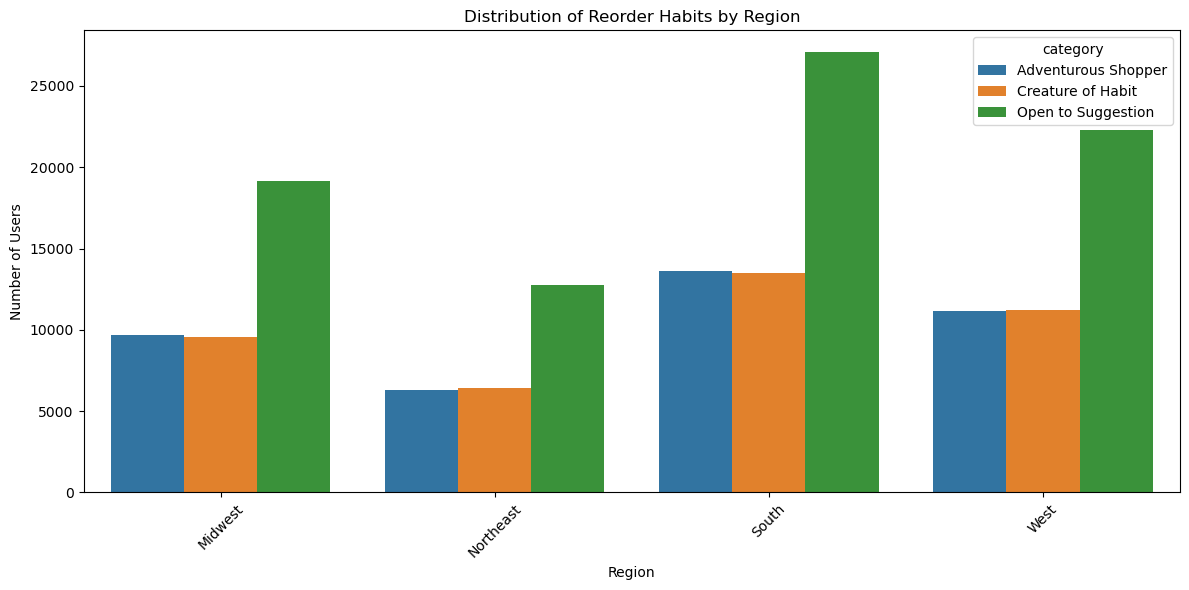

In [227]:
# Count the occurrences of each category within each region
category_by_region = user_activity_with_region.groupby(['region', 'category']).size().reset_index(name='user_count')

# Create a figure and plot
reorder_habit = plt.figure(figsize=(12, 6))  # Adjust the size if needed
sns.barplot(x='region', y='user_count', hue='category', data=category_by_region)

# Add labels and title
plt.xlabel('Region')
plt.ylabel('Number of Users')
plt.title('Distribution of Reorder Habits by Region')

# Rotate x-axis labels for readability
plt.xticks(rotation=45)

# Show the plot
plt.tight_layout()
plt.show()


In [229]:
# Export visualization
# Save to a unique file name
output_dir_1 = '/Users/amyzhang/Desktop/Instacart Basket Analysis/04 Analysis/Visualizations'
file_name_reorder_1 = 'Reorder_Habits_by_Region.png'  
output_path_reorder_1 = os.path.join(output_dir_1, file_name_reorder_1)

# Save the plot to the correct path
reorder_habit.savefig(output_path_reorder_1, format='png')

# Print a message confirming the save
print(f"Reorder habits distribution plot saved to {output_path_reorder_1}")

Reorder habits distribution plot saved to /Users/amyzhang/Desktop/Instacart Basket Analysis/04 Analysis/Visualizations/Reorder_Habits_by_Region.png
